## Нач значения


In [11]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from numba import jit, njit, prange
import csv
from tqdm import tqdm
import pandas as pd
import json


# Физические константы
class Constants:
    G = 6.67e-11  # гравитационная постоянная
    M1 = 2.0e30   # масса звезды (кг)
    M2 = 5.7e26   # масса планеты (кг)
    M3 = 1.4e23   # масса спутника (кг)
    R1 = 696340e3 # радиус звезды (м)
    R2 = 60270e3   # радиус планеты (м)
    R3 = 2575e3   # радиус спутника (м)
    R12 = 1429e9   # начальное расстояние звезда-планета (м)
    R23 = 1222e6   # начальное расстояние планета-спутника (м)
    U2 = 9.7e3     # начальная скорость планеты (м/с)
    U3 = 5.57e3   # начальная скорость спутника (м/с)
    T = 4100.0    # время работы двигателя (с)
    H = 1000e3     # высота орбиты (м)
    M0 = 95.0     # масса полезной нагрузки (кг)
    U = 2500.0    # скорость истечения (м/с)
    koef = 0.001

In [125]:
@njit
def distance(x1, y1, x2, y2):
    return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

@njit
def calculate_forces(t, y):
    r12x, r12y, r13x, r13y = y[0], y[1], y[2], y[3]
    v2x, v2y, v3x, v3y = y[4], y[5], y[6], y[7]

    # Расчёт расстояний
    r12 = np.sqrt(r12x ** 2 + r12y ** 2)      # расстояние от планеты до солнца
    r13 = np.sqrt(r13x ** 2 + r13y ** 2)     # расстояние от спутника до солнца
    r23 = distance(r13x, r13y, r12x, r12y)   # расстояние от спутника до планеты

    # Ускорения для спутника
    f3x = (
        - Constants.G * Constants.M1 * r13x / r13  ** 3
           - Constants.G * Constants.M2 * (r13x - r12x) / r23 ** 3)
    f3y = (
        - Constants.G * Constants.M1 * r13y / r13 ** 3
        - Constants.G * Constants.M2 * (r13y - r12y) / r23 ** 3)

    # Ускорение для планеты
    f2x = (- Constants.G * Constants.M1 * r12x/ r12 ** 3
           + Constants.G * Constants.M3 *  (r13x - r12x) / r23 ** 3)

    f2y = (- Constants.G * Constants.M1 * r12y/ r12 ** 3
           + Constants.G * Constants.M3 *  (r13y - r12y) / r23 ** 3)

    return [v2x, v2y, v3x, v3y, f2x, f2y , f3x, f3y ]

In [38]:
# положение планеты в начальный момент времени
r12x0 = Constants.R1 + Constants.R12 + Constants.R2
r12y0 = 0
v2x0 = 0
v2y0 = Constants.U2

# положение спутника  в начальный момент времени
r13x0 = Constants.R1 + Constants.R12 + Constants.R2 * 2 + Constants.R23 + Constants.R3
r13y0 = 0
v3x0 = 0
v3y0 = Constants.U2 + Constants.U3

mt = 0
y0 = [r12x0, r12y0, r13x0, r13y0,  v2x0, v2y0, v3x0, v3y0]

t0 = 0.0
t_end = int(60 * 60 * 24 * 10759 )
t_span = (0, t_end)

dt = 40000
t_eval = np.arange(0, t_end, dt)


sol = integrate.solve_ivp(
    calculate_forces,
    (t0, t_end),
    y0,
    method='DOP853',
    t_eval=t_eval,
    rtol=1e-5,
    atol=1e-5,
    vectorized=True
)

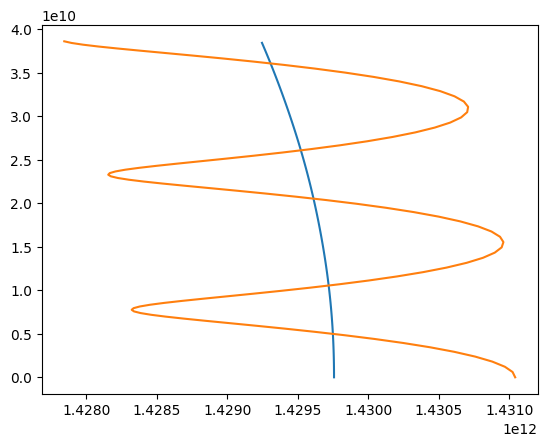

In [40]:
solution = sol.y[:,:100]

plt.plot(solution[0],solution[1])
plt.plot(solution[2],solution[3])

## Нач положение корабля

In [12]:
r12y0, r12x0 = 0 , Constants.R1 + Constants.R12 + Constants.R2
v2x0, v2y0 = 0, Constants.U2
r13y0, r13x0 = 0, Constants.R1 + Constants.R12 + Constants.R2 * 2 + Constants.R23 + Constants.R3
v3x0, v3y0 = 0, Constants.U2 + Constants.U3
r12x,r12y= r12x0,r12y0

In [13]:
# Вспомогательные функции

def m(t, mt) -> np.float64:
    if t >= Constants.T:
        return Constants.M0
    else:
        return (Constants.M0 + mt) / (1 - Constants.koef) - (mt * t) / Constants.T

def dm(t, mt) -> np.float64:
    if t > Constants.T:
        return 0.0
    else:
        return -mt / Constants.T
@njit
def distance(x1, y1, x2, y2) -> np.float64:
    return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

def calculate_forces(t, y, mt):
    rx, ry, r13x, r13y = y[0], y[1], y[2], y[3]
    vx, vy, v3x, v3y = y[4], y[5], y[6], y[7]
    r12x, r12y, v2x, v2y=r12x0, r12y0, y[10], y[11]

    # Расчёт расстояний
    r = np.sqrt(rx ** 2 + ry ** 2)           # расстояние от солнца до ракеты
    r2 = distance(rx, ry, r12x, r12y)        # расстояние от ракеты до планеты
    r3 = distance(rx, ry, r13x, r13y)        # расстояние от ракеты до спутника
    r12 =np.sqrt(r12x ** 2 + r12y ** 2)
    r13 = np.sqrt(r13x ** 2 + r13y ** 2)     # расстояние от спутника до солнца
    r23 = distance(r13x, r13y, r12x, r12y)   # расстояние от спутника до планеты

    v = np.sqrt(vx ** 2 + vy ** 2)
    f_rocket_x = -(Constants.U * dm(t, mt) * vx) / (v * m(t, mt))
    f_rocket_y = -(Constants.U * dm(t, mt) * vy) / (v * m(t, mt))

    f_gravity_x = Constants.G * (
        - Constants.M1 * rx / r ** 3
        - Constants.M2 * (rx - r12x) / r2 ** 3 - Constants.M3 * (rx - r13x) / r3 ** 3)
    f_gravity_y = Constants.G * (
        - Constants.M1 * ry / r ** 3
        - Constants.M2 * (ry - r12y) / r2 ** 3 - Constants.M3 * (ry - r13y) / r3 ** 3)

    # Ускорения для ракеты
    fx = f_rocket_x + f_gravity_x
    fy = f_rocket_y + f_gravity_y

    # Ускорения для спутника
    f3x = (
        # - Constants.G * Constants.M1 * r13x / r13  ** 3
           - Constants.G * Constants.M2 * (r13x - r12x) / r23 ** 3)
    f3y = (
        # - Constants.G * Constants.M1 * r13y / r13 ** 3
        - Constants.G * Constants.M2 * (r13y - r12y) / r23 ** 3)

    # Ускорение для планеты
    f2x = (- Constants.G * Constants.M1 * r12x/ r12 ** 3
           + Constants.G * Constants.M3 *  (r13x - r12x) / r23 ** 3)

    f2y = (- Constants.G * Constants.M1 * r12y/ r12 ** 3
           + Constants.G * Constants.M3 *  (r13y - r12y) / r23 ** 3)

    return np.array([vx, vy, v3x, v3y, fx, fy, f3x, f3y, v2x, v2y, f2x, f2y],dtype=np.float64)

In [14]:
def collision_event(t, y, mt):
    rx, ry, r3x, r3y, _, _, _, _, _, _, _, _= y
    distance = np.sqrt((rx - r3x)**2 + (ry - r3y)**2)
    return distance - Constants.R3
# collision_event.terminal = True

In [15]:
def integrate_trajectory(angle, mt, output=False):
    _angle = np.radians(angle)  # угол в радианах

    v3x = v3x0 - v2x0
    v3y = v3y0 - v2y0

    r12x = r12x0
    r12y = r12y0

    r3x = r13x0 - r12x
    r3y = r13y0 - r12y
    r3 = np.sqrt(r3x ** 2 + r3y ** 2)

    v0 = np.sqrt(Constants.G * Constants.M2 / (Constants.R2 + Constants.H))
    rx0 = (Constants.R2 + Constants.H) * (r3x * np.cos(_angle) - r3y * np.sin(_angle)) / r3
    ry0 = (Constants.R2 + Constants.H) * (r3x * np.sin(_angle) + r3y * np.cos(_angle)) / r3

    r0 = np.sqrt(rx0 ** 2 + ry0 ** 2)

    vx0 = -v0 * ry0 / r0
    vy0 = v0 * rx0 / r0

    rx0 += r12x0
    ry0 += r12y0

    y0 = [rx0, ry0, r13x0, r13y0, vx0, vy0, v3x, v3y,r12x0,r12y0,v2x0,v2y0]

    t0 = 0.0
    t_end = int(60 * 60 * 24 * 19 * 1.4)
    t_span = (0, t_end)
    t_eval = np.linspace(0, t_end, t_end // 4 )

    sol = integrate.solve_ivp(
      calculate_forces,
      t_span,
      y0,
      method='RK45',
      t_eval=t_eval,
      rtol=1e-12,
      atol=1e-12,
      events=collision_event,  # закоментировать для оптимизации
      args = (mt,)
  )

    if output:
        np.savetxt(f'trajectory_mt-{mt}_angle-{angle}.csv', np.column_stack([sol.y[0], sol.y[1], sol.y[2], sol.y[3]]), delimiter=" ", header="x y x3 y3", comments="")

    return sol

In [16]:
_mt = 5900
angle = 125

solution = integrate_trajectory(angle, _mt, output=False)

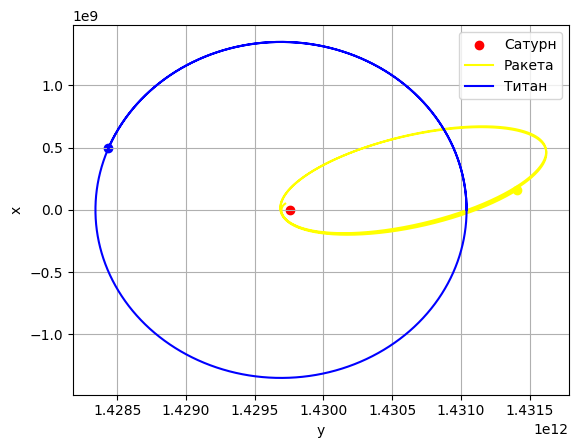

In [17]:
sol = solution.y
plt.scatter(r12x,r12y,label='Сатурн',color='red')
plt.plot(sol[0],sol[1], label='Ракета',color='yellow')
plt.plot(sol[2],sol[3], label='Титан',color='blue')
plt.scatter(sol[2][-1],sol[3][-1],color='blue')
plt.scatter(sol[0][-1],sol[1][-1],color='yellow')


plt.xlabel('y')
plt.ylabel('x')
plt.legend(loc='best')
plt.grid()
plt.show()

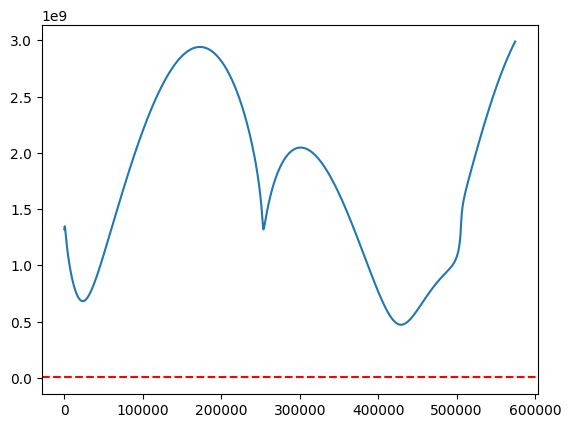

In [145]:
plt.plot(distance(sol[0],sol[1],sol[2],sol[3]))
plt.axhline(y = Constants.R3,color='r', linestyle='--' )
# plt.ylim(0,5e7)

In [146]:
def save_to_csv(data, filename):
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Angle", "MT"])
        writer.writerows(data)

def save_min_dist(data, filename):
    converted_data = [(angle, [(float(mt), float(dist)) for mt, dist in curr_dist]) for angle, curr_dist in data]
    with open(filename, 'w') as f:
        json.dump(converted_data, f, indent=4)
        
def plot_min_dist_time(data):
    plt.plot(distance(data[0],data[1],data[2],data[3]))
    plt.axhline(y = Constants.R3,color='r', linestyle='--' ) 
    plt.show()
        
def plot_min_dist_mt(filename):
    with open(filename, 'r') as f:
        MIN_DIST = json.load(f)
    
    for angle, curr_dist in MIN_DIST:
        mt_values = [mt for mt, dist in curr_dist]
        dist_values = [dist for mt, dist in curr_dist]

        plt.figure(figsize=(8, 5))
        plt.plot(mt_values, dist_values)
        plt.axhline(y=Constants.R3, color = 'r')
        plt.xlabel('Кол-во топлива')
        plt.ylabel('Минимальное расстояние')
        plt.title(f'График зав-ти минимального расстояния от кол-ва топлива для угла: {angle}')
        plt.grid(True)
        plt.show()

In [148]:
MT_MIN = []
MIN_DIST = []
for _angle in range(0, 360, 3):
    CURR_DIST = []
    for _mt in tqdm(np.arange(5400,6000, 1), desc=f"Angle {_angle}"):
        solution = integrate_trajectory(_angle, _mt, output=False)
        sol = solution.y
        CURR_DIST.append((_mt , min(distance(sol[0],sol[1],sol[2],sol[3]))))
        if solution.t_events[0].size > 0:
            print(f'boom: {_mt}', end='\r')
            MT_MIN.append((_angle,_mt))
            break
    MIN_DIST.append((_angle, CURR_DIST))

Angle 0:  13%|█▎        | 76/600 [00:59<06:49,  1.28it/s]


Angle 3:  14%|█▍        | 86/600 [01:09<06:56,  1.23it/s]


Angle 6:  16%|█▌        | 96/600 [01:18<06:52,  1.22it/s]


Angle 9:  18%|█▊        | 106/600 [01:28<06:50,  1.20it/s]


Angle 12:  19%|█▉        | 116/600 [01:34<06:35,  1.22it/s]


Angle 15:  21%|██        | 125/600 [01:45<06:40,  1.18it/s]


Angle 18:  22%|██▎       | 135/600 [01:47<06:08,  1.26it/s]


Angle 21:  24%|██▍       | 145/600 [02:00<06:18,  1.20it/s]


Angle 24:  26%|██▌       | 154/600 [02:06<06:05,  1.22it/s]


Angle 27:  27%|██▋       | 164/600 [02:02<05:25,  1.34it/s]


Angle 30:  29%|██▉       | 173/600 [02:13<05:30,  1.29it/s]


Angle 33:  30%|███       | 182/600 [02:21<05:24,  1.29it/s]


Angle 36:  32%|███▏      | 192/600 [02:27<05:13,  1.30it/s]


Angle 39:  34%|███▎      | 201/600 [02:33<05:04,  1.31it/s]


Angle 42:  35%|███▌      | 210/600 [02:40<04:57,  1.31it/s]


Angle 45:  36%|███▋      | 219/600 [02:43<04:45,  1.34it/s]


Angle 48:  38%|███▊      | 227/600 [02:48<04:36,  1.35it/s]


Angle 51:  39%|███▉      | 236/600 [02:52<04:26,  1.37it/s]


Angle 54:  41%|████      | 245/600 [02:57<04:17,  1.38it/s]


Angle 57:  42%|████▏     | 253/600 [07:14<09:55,  1.72s/it]


Angle 60:  44%|████▎     | 262/600 [04:51<06:15,  1.11s/it]


Angle 63:  45%|████▌     | 270/600 [05:06<06:14,  1.13s/it]


Angle 66:  46%|████▋     | 279/600 [03:14<03:44,  1.43it/s]


Angle 69:  48%|████▊     | 287/600 [03:17<03:35,  1.46it/s]


Angle 72:  49%|████▉     | 295/600 [03:31<03:38,  1.40it/s]


Angle 75:  50%|█████     | 303/600 [03:43<03:39,  1.35it/s]


Angle 78:  52%|█████▏    | 311/600 [03:52<03:36,  1.34it/s]


Angle 81:  53%|█████▎    | 319/600 [03:36<03:10,  1.47it/s]


Angle 84:  55%|█████▍    | 327/600 [03:47<03:10,  1.44it/s]


Angle 87:  56%|█████▌    | 335/600 [04:06<03:15,  1.36it/s]


Angle 90:  57%|█████▋    | 343/600 [04:05<03:04,  1.40it/s]


Angle 93:  58%|█████▊    | 350/600 [04:08<02:57,  1.41it/s]


Angle 96:   2%|▏         | 11/600 [00:11<09:52,  1.01s/it]


Angle 99:   4%|▍         | 23/600 [00:18<07:41,  1.25it/s]


Angle 102:   6%|▌         | 35/600 [00:29<08:02,  1.17it/s]


Angle 105:   8%|▊         | 47/600 [00:37<07:18,  1.26it/s]


Angle 108:  10%|▉         | 58/600 [00:51<08:05,  1.12it/s]


Angle 111:  12%|█▏        | 70/600 [01:01<07:43,  1.14it/s]


Angle 114:  14%|█▎        | 81/600 [01:01<06:36,  1.31it/s]


Angle 117:  15%|█▌        | 91/600 [01:11<06:39,  1.27it/s]


Angle 120:  17%|█▋        | 102/600 [01:23<06:48,  1.22it/s]


Angle 123:  19%|█▊        | 112/600 [01:25<06:11,  1.31it/s]


Angle 126:  20%|██        | 122/600 [01:32<06:03,  1.32it/s]


Angle 129:  22%|██▏       | 132/600 [01:41<05:58,  1.30it/s]


Angle 132:  24%|██▎       | 141/600 [01:46<05:47,  1.32it/s]


Angle 135:   0%|          | 0/600 [00:00<?, ?it/s]


Angle 138:   1%|          | 7/600 [00:06<08:37,  1.15it/s]


Angle 141:   2%|▏         | 14/600 [00:11<07:49,  1.25it/s]


Angle 144:   4%|▎         | 21/600 [00:17<08:09,  1.18it/s]


Angle 147:   5%|▍         | 29/600 [00:21<07:09,  1.33it/s]


Angle 150:   6%|▌         | 36/600 [00:27<07:17,  1.29it/s]


Angle 153:   7%|▋         | 42/600 [00:34<07:35,  1.23it/s]


Angle 156:   8%|▊         | 49/600 [00:36<06:52,  1.34it/s]


Angle 159:   9%|▉         | 54/600 [00:39<06:36,  1.38it/s]


Angle 162:  10%|▉         | 59/600 [00:43<06:35,  1.37it/s]


Angle 165:  10%|▉         | 59/600 [00:43<06:39,  1.35it/s]


Angle 168:   7%|▋         | 42/600 [00:31<07:03,  1.32it/s]


Angle 171:   0%|          | 0/600 [00:00<?, ?it/s]


Angle 174:  18%|█▊        | 110/600 [01:22<06:05,  1.34it/s]


Angle 177:  19%|█▉        | 113/600 [01:22<05:55,  1.37it/s]


Angle 180:  20%|█▉        | 118/600 [01:27<05:58,  1.34it/s]


Angle 183:  21%|██        | 124/600 [01:31<05:53,  1.35it/s]


Angle 186:  22%|██▏       | 130/600 [01:35<05:43,  1.37it/s]


Angle 189:  23%|██▎       | 137/600 [01:40<05:40,  1.36it/s]


Angle 192:  24%|██▍       | 143/600 [01:46<05:39,  1.35it/s]


Angle 195:  25%|██▌       | 150/600 [01:50<05:30,  1.36it/s]


Angle 198:  26%|██▌       | 157/600 [01:56<05:29,  1.34it/s]


Angle 201:  27%|██▋       | 163/600 [02:00<05:23,  1.35it/s]


Angle 204:   2%|▏         | 11/600 [00:09<08:39,  1.13it/s]


Angle 207:   6%|▌         | 33/600 [00:27<07:45,  1.22it/s]


Angle 210:   9%|▉         | 55/600 [00:42<07:03,  1.29it/s]


Angle 213:  13%|█▎        | 77/600 [00:58<06:37,  1.32it/s]


Angle 216:  16%|█▋        | 99/600 [01:14<06:18,  1.32it/s]


Angle 219:  20%|██        | 120/600 [01:29<05:57,  1.34it/s]


Angle 222:  24%|██▎       | 141/600 [01:44<05:39,  1.35it/s]


Angle 225:  27%|██▋       | 162/600 [01:58<05:21,  1.36it/s]


Angle 228:  30%|███       | 182/600 [02:21<05:25,  1.28it/s]


Angle 231:  34%|███▍      | 203/600 [02:25<04:43,  1.40it/s]


Angle 234:  37%|███▋      | 222/600 [02:38<04:29,  1.40it/s]


Angle 237:  40%|████      | 241/600 [02:46<04:08,  1.44it/s]


Angle 240:  43%|████▎     | 260/600 [02:56<03:51,  1.47it/s]


Angle 243:  46%|████▋     | 279/600 [03:07<03:36,  1.49it/s]


Angle 246:  45%|████▌     | 272/600 [03:04<03:41,  1.48it/s]


Angle 249:  46%|████▌     | 274/600 [03:04<03:39,  1.49it/s]


Angle 252:  46%|████▋     | 278/600 [03:05<03:35,  1.50it/s]


Angle 255:  47%|████▋     | 283/600 [03:10<03:33,  1.49it/s]


Angle 258:  48%|████▊     | 288/600 [03:13<03:29,  1.49it/s]


Angle 261:   0%|          | 0/600 [00:00<?, ?it/s]


Angle 264:   1%|          | 7/600 [00:06<09:09,  1.08it/s]


Angle 267:   3%|▎         | 19/600 [00:15<07:50,  1.23it/s]


Angle 270:   5%|▌         | 30/600 [00:23<07:25,  1.28it/s]


Angle 273:   7%|▋         | 41/600 [00:31<07:02,  1.32it/s]


Angle 276:  76%|███████▌  | 456/600 [04:58<01:34,  1.53it/s]


Angle 279:  78%|███████▊  | 470/600 [05:05<01:24,  1.54it/s]


Angle 282:  81%|████████  | 484/600 [05:15<01:15,  1.53it/s]


Angle 285:  83%|████████▎ | 497/600 [05:23<01:07,  1.53it/s]


Angle 288:  85%|████████▌ | 510/600 [05:30<00:58,  1.54it/s]


Angle 291:  87%|████████▋ | 523/600 [05:37<00:49,  1.55it/s]


Angle 294:  89%|████████▉ | 536/600 [05:58<00:42,  1.50it/s]


Angle 297:  91%|█████████▏| 548/600 [06:07<00:34,  1.49it/s]


Angle 300:  93%|█████████▎| 560/600 [06:04<00:26,  1.54it/s]


Angle 303:  95%|█████████▌| 572/600 [06:11<00:18,  1.54it/s]


Angle 306:  97%|█████████▋| 583/600 [06:14<00:10,  1.56it/s]


Angle 309:  99%|█████████▉| 595/600 [06:19<00:03,  1.57it/s]


Angle 321:   0%|          | 0/600 [00:00<?, ?it/s]


Angle 324:   8%|▊         | 51/600 [00:41<07:21,  1.24it/s]


Angle 327:  15%|█▍        | 88/600 [01:08<06:40,  1.28it/s]


Angle 330:  20%|██        | 120/600 [01:31<06:07,  1.30it/s]


Angle 333:  25%|██▍       | 148/600 [01:51<05:40,  1.33it/s]


Angle 336:   0%|          | 0/600 [00:00<?, ?it/s]


Angle 339:   1%|          | 7/600 [00:06<08:56,  1.11it/s]


Angle 342:   3%|▎         | 16/600 [00:12<07:53,  1.23it/s]


Angle 345:   4%|▍         | 26/600 [00:20<07:31,  1.27it/s]


Angle 348:   6%|▌         | 36/600 [00:27<07:12,  1.30it/s]


Angle 351:   8%|▊         | 46/600 [00:35<07:07,  1.29it/s]


Angle 354:   9%|▉         | 56/600 [00:42<06:57,  1.30it/s]


Angle 357:  11%|█         | 66/600 [00:50<06:48,  1.31it/s]

In [149]:
save_to_csv(MT_MIN,'result_new.csv')

In [139]:
save_min_dist(MIN_DIST,'result_min_dist.json')

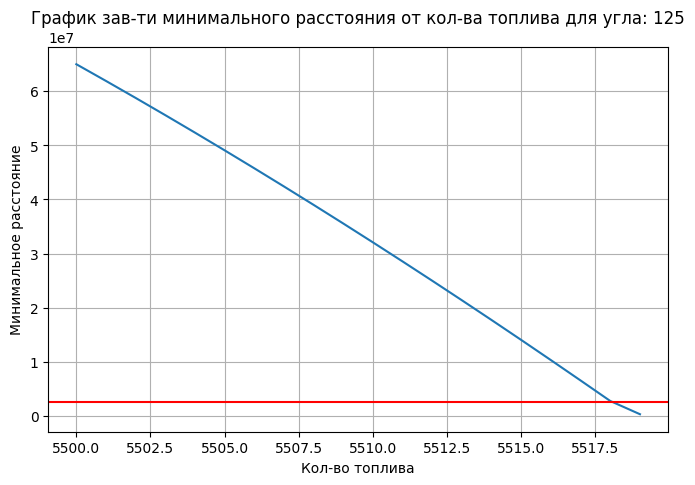

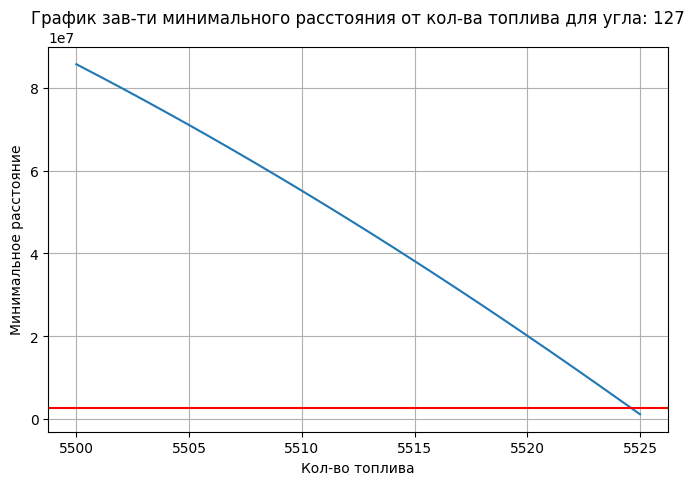

In [140]:
plot_min_dist_mt('result_min_dist.json')

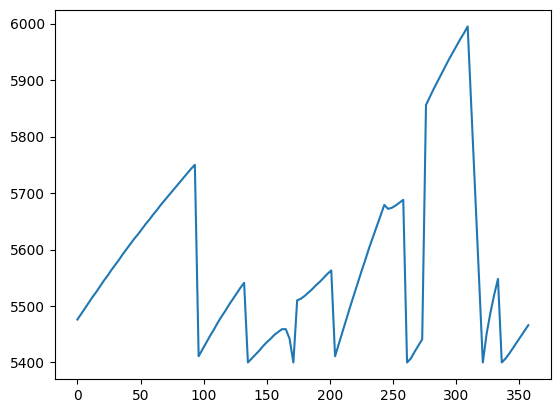

In [150]:
data=pd.read_csv('result_new.csv',sep=',')
plt.plot(data.Angle,data.MT)

In [34]:
from scipy.optimize import minimize, differential_evolution

def optimize():
    def _minimize(x):
        _angle, _mt = x 
        solution = integrate_trajectory(_angle, _mt, output=False)
        sol = solution.y 
        R = min(distance(sol[0], sol[1], sol[2], sol[3]))
        print(f'angle: {_angle}, mt: {_mt}, R: {R}')
        return max(R,0) + _mt
    
    # res = minimize(_minimize, x0, method='nelder-mead', options={'disp':True})
    bounds = [(0, 360), (5300, 5700)]
    res = differential_evolution(_minimize, bounds, strategy='best1bin', popsize=15, mutation=(0.5, 1), recombination=0.7, disp=True)
    return res

In [35]:
optimize()

angle: 135.16580990911905, mt: 5602.616712433672, R: 251952391.03788832
angle: 185.15054575968182, mt: 5300.0574407122585, R: 2324084.6799511164
angle: 108.58626763699684, mt: 5329.382134828018, R: 5757810.17528151
angle: 94.25945986366361, mt: 5402.323060450336, R: 3370256.014297155
angle: 59.77658983669356, mt: 5664.682876860615, R: 17341784.632525712
angle: 73.01848448564854, mt: 5438.467891758132, R: 441399585.51564777
angle: 211.29591542850108, mt: 5697.105106227535, R: 259732077.47047135
angle: 286.49068773478075, mt: 5591.120118065989, R: 880720356.5926275
angle: 161.5111448514466, mt: 5391.796458421297, R: 108468454.00948808
angle: 127.8178708380535, mt: 5425.029819154889, R: 133712772.03480594
angle: 154.11381279041834, mt: 5639.890327367364, R: 192070180.13816935
angle: 103.23889763676175, mt: 5449.528978265141, R: 28449672.72903367
angle: 239.79879588176033, mt: 5631.53894771139, R: 68618918.42864488
angle: 357.72426554810124, mt: 5568.6540713593495, R: 195730199.5279288
ang

KeyboardInterrupt: 